In [44]:
import tensorflow as tf
import tensorflow.keras as keras
import os
import sys
from importlib import reload
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import probdownscale
reload(probdownscale.TaskExtractor)
reload(probdownscale.MetaTrain)
from probdownscale.MetaTrain import MetaSGD

from probdownscale.TaskExtractor import TaskExtractor
import math
import numpy as np
import netCDF4 as nc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow_probability import distributions as tfd
from matplotlib import pyplot as plt

## 1. Debug TaskExtractor

In [45]:
file_path_g_05 = r'C:\Users\96349\Documents\Downscale_data\MERRA2\G5NR_aerosol_variables_over_MiddleEast_daily_20050516-20060515.nc'
file_path_g_06 =  r'C:\Users\96349\Documents\Downscale_data\MERRA2\G5NR_aerosol_variables_over_MiddleEast_daily_20060516-20070515.nc'
file_path_m = r'C:\Users\96349\Documents\Downscale_data\MERRA2\MERRA2_aerosol_variables_over_MiddleEast_daily_20000516-20180515.nc'
target_var = 'BCSMASS'

# read data
g05_data = nc.Dataset(file_path_g_05)
g06_data = nc.Dataset(file_path_g_06)
m_data_nc = nc.Dataset(file_path_m)

# define lat&lon of MERRA, G5NR and mete
M_lons = m_data_nc.variables['lon'][:15]
# self.M_lons = (M_lons-M_lons.mean())/M_lons.std()
M_lats = m_data_nc.variables['lat'][:15]
# self.M_lats = (M_lats-M_lats.mean())/M_lats.std()
G_lons = g05_data.variables['lon'][:30]
# self.G_lons = (G_lons-G_lons.mean())/G_lons.std()
G_lats = g05_data.variables['lat'][:30]

# extract target data
g_data = np.concatenate((g05_data.variables[target_var][:, :30, :30], g06_data.variables[target_var][:, :30, :30]), axis=0)
m_data = m_data_nc.variables[target_var][5*365:7*365, :15, :15]

C:\Users\96349\anaconda3\envs\Downscale_env\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
C:\Users\96349\anaconda3\envs\Downscale_env\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
C:\Users\96349\anaconda3\envs\Downscale_env\lib\site-packag

In [46]:
train_g_data, test_g_data = g_data[:657], g_data[657:]
train_m_data, test_m_data = m_data[:657], m_data[657:]
data = [train_g_data, train_m_data]
lats_lons = [G_lats, G_lons, M_lats, M_lons]
task_dim = 3
test_proportion = 0.3
n_lag = 10
taskextractor = TaskExtractor(data, lats_lons, task_dim, test_proportion, n_lag)

In [47]:
train_x, train_y, test_x, test_y, location, init = taskextractor._get_one_random_task(return_init=True)

In [32]:
train_x, train_y, test_x, test_y, locations = taskextractor.get_random_tasks(10)


In [35]:
train_x, train_y, test_x, test_y, locations = taskextractor.get_random_tasks(locations=locations[:4])

In [14]:
from random import sample
sample([1,2,3,4], 4)

[3, 1, 4, 2]

In [99]:
a = list(range(10))
a

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [100]:
a[6:9]

[6, 7, 8]

## 2. Test Network

In [61]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow_probability import distributions as tfd

In [62]:
# the last channel is the comonents
alpha = np.random.rand(3,2,5)
alpha = alpha/alpha.sum()
mu = np.random.rand(3, 2, 5)
mu = np.abs(mu)
test_md = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Gamma(concentration=mu, rate=mu))

In [68]:
test_md.sample(100).numpy().mean(axis=0)

array([[0.99199912, 1.09824118],
       [0.9757111 , 0.86317665],
       [0.99805722, 0.88828781]])

In [120]:
log_like = test_md.log_prob(np.ones((3,2))*-0.001)
#-tf.reduce_mean(log_like, axis=-1)
log_like

# when the Y is really small, log_prob return a positive log likelihood

<tf.Tensor: shape=(3, 2), dtype=float64, numpy=
array([[nan, nan],
       [nan, nan],
       [nan, nan]])>

In [313]:
test_md.mean()

<tf.Tensor: shape=(3, 2), dtype=float64, numpy=
array([[0.15880819, 0.10569395],
       [0.17997603, 0.15908541],
       [0.20016422, 0.19627221]])>

In [80]:
log_like

<tf.Tensor: shape=(3, 2), dtype=float64, numpy=
array([[-1.07151844, -1.96976935],
       [-0.88054633, -1.06112697],
       [-1.63395563, -0.41498473]])>

In [160]:
a =  np.random.rand(3,3,3)
#a = (a - a.min())/(a.max() - a.min())
a = a/a.sum()
a.sum()

1.0

In [20]:
# define necessary tool functions
components = 100
no_parameters = 2

def nnelu(input):
    return tf.add(tf.constant(1, dtype=tf.float32), tf.nn.elu(input))

def slice_parameter_vectors(parameter_vector, no_parameters):
    return [parameter_vector[:, i * task_dim*task_dim*components:(i + 1) *task_dim*task_dim*components] for i in range(no_parameters)]

def gamma_loss(y, parameter_vector):
    alpha, mu, sigma = slice_parameter_vectors(parameter_vector, 3)  # Unpack parameter vectors
    #print(alpha.shape, mu.shape)
    alpha1 = tf.reshape(alpha, (tf.shape(alpha)[0], task_dim, task_dim, components))
    mu1 = tf.reshape(mu, (tf.shape(mu)[0], task_dim, task_dim, components))
    sigma1 = tf.reshape(sigma,  (tf.shape(sigma)[0], task_dim, task_dim, components))
    #print(alpha1.shape, mu1.shape)
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha1),
        components_distribution=tfd.Gamma(
        concentration=mu1, rate=sigma1)
    )

    log_likelihood = gm.log_prob(y)  # Evaluate log-probability of y
    #print(log_likelihood)
    return -tf.reduce_mean(log_likelihood, axis=-1)

def exponential_loss(y, parameter_vector):
    alpha, mu = slice_parameter_vectors(parameter_vector, 2)  # Unpack parameter vectors
    #print(alpha.shape, mu.shape)
    alpha1 = tf.reshape(alpha, (tf.shape(alpha)[0], task_dim, task_dim, components))
    mu1 = tf.reshape(mu, (tf.shape(mu)[0], task_dim, task_dim, components))
    #print(alpha1.shape, mu1.shape)
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha1),
        components_distribution=tfd.Exponential(
        rate=mu1)
    )

    log_likelihood = gm.log_prob(y)  # Evaluate log-probability of y
    #print(log_likelihood)
    return -tf.reduce_mean(log_likelihood, axis=-1)

def gamma_mean_loss(y, parameter_vector):
    alpha, mu, sigma = slice_parameter_vectors(parameter_vector, 3)  # Unpack parameter vectors
    #print(alpha.shape, mu.shape)
    alpha1 = tf.reshape(alpha, (tf.shape(alpha)[0], task_dim, task_dim, components))
    mu1 = tf.reshape(mu, (tf.shape(mu)[0], task_dim, task_dim, components))
    sigma1 = tf.reshape(sigma,  (tf.shape(sigma)[0], task_dim, task_dim, components))
    #print(alpha1.shape, mu1.shape)
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha1),
        components_distribution=tfd.Gamma(
        concentration=mu1, rate=sigma1)
    )
    mae = tf.keras.losses.MeanAbsoluteError()
    return mae(gm.mean(), y) 


tf.keras.utils.get_custom_objects().update({'nnelu': layers.Activation(nnelu)})

def plot_history(history, title):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    
def model_generator(n_para=2):
    # define MDN Exponentialmodel
    # input dim (time, channel, rows, cols)
    input1 = layers.Input(shape=(n_lag, 1, task_dim, task_dim)) 
    input1 = layers.BatchNormalization()(input1)
    input2 = layers.Input(shape=(task_dim, task_dim, 1))
    input2 = layers.BatchNormalization()(input2)
    input3 = layers.Input(shape=(1))
    input3 = layers.BatchNormalization()(input3)

    X = layers.ConvLSTM2D(filters=20, kernel_size=(1,2), activation='tanh', return_sequences=True)(input1)
    X = layers.ConvLSTM2D(filters=20, kernel_size=(1,2), activation='relu', return_sequences=True)(X)
    X = layers.ConvLSTM2D(filters=20, kernel_size=(1,1), activation='relu')(X)
    X = layers.Flatten()(X)
    X = layers.Dense(512, activation='relu')(X)
    X = layers.BatchNormalization()(X)
    X = layers.Dense(300, activation='relu')(X)

    X1 = layers.Conv2D(20, (2,2), activation='tanh')(input2)
    X1 = layers.Flatten()(X1)
    X2 = layers.BatchNormalization()(input3)
    X2 = layers.Dense(30, activation='relu')(X2)

    X = layers.Concatenate()([X, X1, X2])
    X = layers.Dense(128, activation='relu')(X)
    X = layers.BatchNormalization()(X)
    X = layers.Dense(128, activation='relu')(X)
    X = layers.BatchNormalization()(X)
    X = layers.Dense(128, activation='relu')(X)
    X = layers.BatchNormalization()(X)
    X = layers.Concatenate()([X, X1, X2])
    X = layers.Dense(128, activation='relu')(X)
    X = layers.BatchNormalization()(X)
    X = layers.Dense(128, activation='relu')(X)
    X = layers.BatchNormalization()(X)
    X = layers.Dense(128, activation='relu')(X)
    X = layers.BatchNormalization()(X)
    X = layers.Concatenate()([X, X1, X2])
    X = layers.Dense(128, activation='relu')(X)
    X = layers.BatchNormalization()(X)
    X = layers.Dense(128, activation='relu')(X)
    X = layers.BatchNormalization()(X)
    X = layers.Dense(128, activation='relu')(X)
    X = layers.BatchNormalization()(X)
    X = layers.Concatenate()([X, X1, X2])
    X = layers.Dense(128, activation='relu')(X)
    X = layers.BatchNormalization()(X)
    X = layers.Dense(128, activation='relu')(X)
    X = layers.BatchNormalization()(X)
    X = layers.Dense(128, activation='relu')(X)
    X = layers.BatchNormalization()(X)
    X = layers.Concatenate()([X, X1, X2])
    X = layers.Dense(128, activation='relu')(X)
    X = layers.BatchNormalization()(X)
    X = layers.Dense(128, activation='relu')(X)
    X = layers.BatchNormalization()(X)
    X = layers.Dense(128, activation='relu')(X)
    X = layers.BatchNormalization()(X)
    if n_para ==2:
        alphas = layers.Dense(components*task_dim*task_dim, activation="softmax")(X)
        #alphas = layers.Reshape((task_dim, task_dim, components), name="alphas")(alphas)
        mus = layers.Dense(components*task_dim*task_dim, activation='nnelu')(X)
        #mus = layers.Reshape((task_dim, task_dim, components) ,name="mus")(mus)
        output = layers.Concatenate()([alphas, mus])
        model = Model([input1, input2, input3], output)
    else:
        alphas = layers.Dense(components*task_dim*task_dim, activation="softmax")(X)
        #alphas = layers.Reshape((task_dim, task_dim, components), name="alphas")(alphas)
        mus = layers.Dense(components*task_dim*task_dim, activation='nnelu')(X)
        #mus = layers.Reshape((task_dim, task_dim, components) ,name="mus")(mus)
        sigmas = layers.Dense(components*task_dim*task_dim, activation='nnelu')(X)
        output = layers.Concatenate()([alphas, mus, sigmas])
        model = Model([input1, input2, input3], output)
    return model

Epoch 1/200
15/15 [==============================] - 18s 139ms/step - loss: 71.4928 - val_loss: 181.3611
Epoch 2/200
15/15 [==============================] - 1s 45ms/step - loss: 71.1275 - val_loss: 189.5304
Epoch 3/200
15/15 [==============================] - 1s 47ms/step - loss: 69.9280 - val_loss: 187.0380
Epoch 4/200
15/15 [==============================] - 1s 47ms/step - loss: 69.1827 - val_loss: 178.7140
Epoch 5/200
15/15 [==============================] - 1s 47ms/step - loss: 68.1245 - val_loss: 168.0390
Epoch 6/200
15/15 [==============================] - 1s 49ms/step - loss: 65.9037 - val_loss: 157.2974
Epoch 7/200
15/15 [==============================] - 1s 47ms/step - loss: 65.6374 - val_loss: 147.6293
Epoch 8/200
15/15 [==============================] - 1s 47ms/step - loss: 64.3810 - val_loss: 139.8438
Epoch 9/200
15/15 [==============================] - 1s 48ms/step - loss: 63.2070 - val_loss: 133.2554
Epoch 10/200
15/15 [==============================] - 1s 46ms/step - lo

Epoch 82/200
15/15 [==============================] - 1s 49ms/step - loss: 9.4297 - val_loss: nan
Epoch 83/200
15/15 [==============================] - 1s 50ms/step - loss: 9.6078 - val_loss: nan
Epoch 84/200
15/15 [==============================] - 1s 51ms/step - loss: 9.6781 - val_loss: nan
Epoch 85/200
15/15 [==============================] - 1s 59ms/step - loss: 9.5737 - val_loss: nan
Epoch 86/200
15/15 [==============================] - 1s 53ms/step - loss: 8.9968 - val_loss: nan
Epoch 87/200
15/15 [==============================] - 1s 50ms/step - loss: 9.3547 - val_loss: nan
Epoch 88/200
15/15 [==============================] - 1s 53ms/step - loss: 8.8883 - val_loss: nan
Epoch 89/200
15/15 [==============================] - 1s 54ms/step - loss: 9.2559 - val_loss: nan
Epoch 90/200
15/15 [==============================] - 1s 51ms/step - loss: 8.7751 - val_loss: nan
Epoch 91/200
15/15 [==============================] - 1s 47ms/step - loss: 8.6156 - val_loss: nan
Epoch 92/200
15/15 [

15/15 [==============================] - 1s 40ms/step - loss: 6.6490 - val_loss: nan
Epoch 164/200
15/15 [==============================] - 1s 56ms/step - loss: 6.7017 - val_loss: nan
Epoch 165/200
15/15 [==============================] - 1s 53ms/step - loss: 6.7021 - val_loss: nan
Epoch 166/200
15/15 [==============================] - 1s 47ms/step - loss: 6.7058 - val_loss: nan
Epoch 167/200
15/15 [==============================] - 1s 47ms/step - loss: 6.7690 - val_loss: nan
Epoch 168/200
15/15 [==============================] - 1s 53ms/step - loss: 6.5607 - val_loss: nan
Epoch 169/200
15/15 [==============================] - 1s 46ms/step - loss: 6.6592 - val_loss: nan
Epoch 170/200
15/15 [==============================] - 1s 48ms/step - loss: 6.5942 - val_loss: nan
Epoch 171/200
15/15 [==============================] - 1s 45ms/step - loss: 6.6690 - val_loss: nan
Epoch 172/200
15/15 [==============================] - 1s 62ms/step - loss: 6.6606 - val_loss: 7.3791
Epoch 173/200
15/15 [

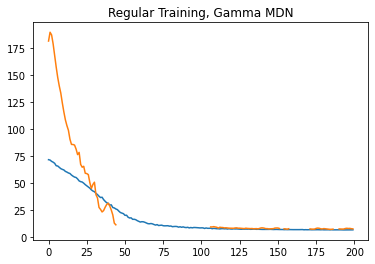

In [28]:
# define MDN Gamma model
MDN_model_ref_gamma = model_generator(n_para=3)
#MDN_model_ref_gamma.set_weights(meta_learner.meta_model.get_weights())
MDN_model_ref_gamma.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss=gamma_loss)
history_gamma = MDN_model_ref_gamma.fit(train_x, train_y, epochs=200, validation_data=[test_x, test_y])
plot_history(history_gamma, 'Regular Training, Gamma MDN')

In [ ]:
plt.plot(history_gamma)

Epoch 1/80
16/16 [==============================] - 11s 81ms/step - loss: 199.0508 - val_loss: 204.0836
Epoch 2/80
16/16 [==============================] - 0s 26ms/step - loss: 199.0134 - val_loss: 204.0834
Epoch 3/80
16/16 [==============================] - 0s 26ms/step - loss: 198.8674 - val_loss: 204.0824
Epoch 4/80
16/16 [==============================] - 0s 26ms/step - loss: 198.8008 - val_loss: 204.0806
Epoch 5/80
16/16 [==============================] - 0s 28ms/step - loss: 198.7091 - val_loss: 204.0780
Epoch 6/80
16/16 [==============================] - 1s 46ms/step - loss: 198.3481 - val_loss: 204.0742
Epoch 7/80
16/16 [==============================] - 1s 68ms/step - loss: 197.6625 - val_loss: 204.0688
Epoch 8/80
16/16 [==============================] - 1s 42ms/step - loss: 196.7148 - val_loss: 204.0617
Epoch 9/80
16/16 [==============================] - 0s 28ms/step - loss: 194.7108 - val_loss: 204.0524
Epoch 10/80
16/16 [==============================] - 0s 28ms/step - loss

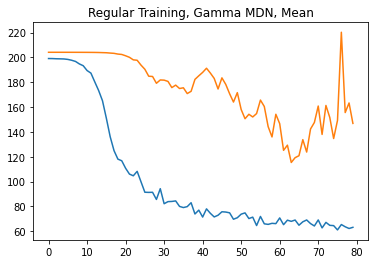

In [21]:
# define MDN Gamma Mean model
MDN_model_ref_gamma_mean = model_generator(n_para=3)
MDN_model_ref_gamma_mean.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss=gamma_mean_loss)
history_gamma_mean = MDN_model_ref_gamma_mean.fit(train_x, train_y, epochs=80, validation_data=[test_x, test_y])
plot_history(history_gamma_mean, 'Regular Training, Gamma MDN, Mean')

Epoch 1/200
16/16 [==============================] - 12s 100ms/step - loss: 62.5850 - val_loss: 165.7774
Epoch 2/200
16/16 [==============================] - 1s 34ms/step - loss: 53.1651 - val_loss: 166.4678
Epoch 3/200
16/16 [==============================] - 1s 37ms/step - loss: 45.8832 - val_loss: 160.6608
Epoch 4/200
16/16 [==============================] - 1s 35ms/step - loss: 39.7374 - val_loss: 154.2601
Epoch 5/200
16/16 [==============================] - 1s 37ms/step - loss: 34.3650 - val_loss: 147.1115
Epoch 6/200
16/16 [==============================] - 1s 38ms/step - loss: 30.6276 - val_loss: 139.9658
Epoch 7/200
16/16 [==============================] - 1s 36ms/step - loss: 27.1943 - val_loss: 133.1129
Epoch 8/200
16/16 [==============================] - 1s 37ms/step - loss: 24.5809 - val_loss: 126.7268
Epoch 9/200
16/16 [==============================] - 1s 34ms/step - loss: 21.9697 - val_loss: 121.3874
Epoch 10/200
16/16 [==============================] - 1s 40ms/step - lo

16/16 [==============================] - 1s 37ms/step - loss: 6.3449 - val_loss: 7.7996
Epoch 162/200
16/16 [==============================] - 1s 36ms/step - loss: 6.3529 - val_loss: 7.4890
Epoch 163/200
16/16 [==============================] - 1s 36ms/step - loss: 6.3679 - val_loss: 7.3364
Epoch 164/200
16/16 [==============================] - 1s 36ms/step - loss: 6.3836 - val_loss: 7.4411
Epoch 165/200
16/16 [==============================] - 1s 42ms/step - loss: 6.3841 - val_loss: 8.2016
Epoch 166/200
16/16 [==============================] - 1s 43ms/step - loss: 6.3912 - val_loss: 8.0978
Epoch 167/200
16/16 [==============================] - 1s 42ms/step - loss: 6.3787 - val_loss: 8.2480
Epoch 168/200
16/16 [==============================] - 1s 41ms/step - loss: 6.3383 - val_loss: 7.8294
Epoch 169/200
16/16 [==============================] - 1s 40ms/step - loss: 6.3614 - val_loss: 7.4916
Epoch 170/200
16/16 [==============================] - 1s 39ms/step - loss: 6.3533 - val_loss: 7

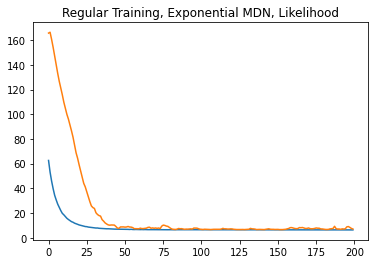

In [24]:
# define MDN Exponentialmodel
MDN_model_ref_exponential = model_generator(n_para=2)
MDN_model_ref_exponential.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss=exponential_loss)
history_exponential = MDN_model_ref_exponential.fit(train_x, train_y, epochs=200, validation_data=[test_x, test_y])
plot_history(history_exponential, 'Regular Training, Exponential MDN, Likelihood')

The MAE between mean of MD and Y is not a stable loss to track.

## 3. Debug Meta Learning Algorithm

In [13]:
# define necessary tool functions
components = 100
no_parameters = 3
data = [g_data, m_data]
lats_lons = [G_lats, G_lons, M_lats, M_lons]
task_dim = 3
test_proportion = 0.5
n_lag = 10

MDN_model = model_generator(n_para=no_parameters)

# define TaskExtractor

taskextractor = TaskExtractor(data, lats_lons, task_dim, test_proportion, n_lag)

In [14]:
reload(probdownscale.MetaTrain)
from probdownscale.MetaTrain import MetaSGD
# define meta learner
meta_optimizer = tf.keras.optimizers.Adam(0.0001)
inner_step = 1
inner_optimizer = tf.keras.optimizers.Adam(0.0001)

meta_learner = MetaSGD(MDN_model_ref_gamma, gamma_loss,  meta_optimizer, inner_step, inner_optimizer, taskextractor)

Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 1 / 20  Basic training step:  1 / 8 loss:  6.619729
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 1 / 20  Basic training step:  2 / 8 loss:  6.5246787
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 1 / 20  Basic training step:  3 / 8 loss:  6.4987016
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 1 / 20  Basic training step:  4 / 8 loss:  6.3961782
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 1 / 20  Basic training step:  5 / 8 loss:  6.333024
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 1 / 20  Basic training step:  6 / 8 loss:  6.316188
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 1 / 20  Basic training step:  7 / 8 loss:  6.2540045
Meta lr: <tf.Variable 'learning_rate:0' shap

Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 4 / 20  Basic training step:  7 / 8 loss:  6.076075
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 4 / 20  Basic training step:  8 / 8 loss:  6.0605016
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 4 / 20 Bootstrap training step: 1 / 10 loss:  6.020775
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 4 / 20 Bootstrap training step: 2 / 10 loss:  5.982307
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 4 / 20 Bootstrap training step: 3 / 10 loss:  6.007864
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 4 / 20 Bootstrap training step: 4 / 10 loss:  6.025493
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 4 / 20 Bootstrap training step: 5 / 10 loss:  6.0041146
Meta lr: <tf.Variable 'learning

Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 7 / 20 Bootstrap training step: 5 / 10 loss:  5.988162
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 7 / 20 Bootstrap training step: 6 / 10 loss:  5.968732
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 7 / 20 Bootstrap training step: 7 / 10 loss:  5.9670806
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 7 / 20 Bootstrap training step: 8 / 10 loss:  5.9179993
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 7 / 20 Bootstrap training step: 9 / 10 loss:  6.06167
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 7 / 20 Bootstrap training step: 10 / 10 loss:  5.973663
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 8 / 20  Basic training step:  1 / 8 loss:  5.967285
Meta lr: <tf.Variable 'learn

Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 11 / 20  Basic training step:  1 / 8 loss:  5.9518213
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 11 / 20  Basic training step:  2 / 8 loss:  5.9455957
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 11 / 20  Basic training step:  3 / 8 loss:  5.9173365
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 11 / 20  Basic training step:  4 / 8 loss:  5.982023
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 11 / 20  Basic training step:  5 / 8 loss:  5.953373
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 11 / 20  Basic training step:  6 / 8 loss:  5.860841
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 11 / 20  Basic training step:  7 / 8 loss:  5.922371
Meta lr: <tf.Variable 'learning_rate:0

Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 14 / 20  Basic training step:  6 / 8 loss:  5.8539467
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 14 / 20  Basic training step:  7 / 8 loss:  5.9098096
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 14 / 20  Basic training step:  8 / 8 loss:  5.860016
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 14 / 20 Bootstrap training step: 1 / 10 loss:  5.934077
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 14 / 20 Bootstrap training step: 2 / 10 loss:  5.867397
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 14 / 20 Bootstrap training step: 3 / 10 loss:  5.873061
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 14 / 20 Bootstrap training step: 4 / 10 loss:  5.9441833
Meta lr: <tf.Variable 'lea

Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 17 / 20 Bootstrap training step: 3 / 10 loss:  5.8416934
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 17 / 20 Bootstrap training step: 4 / 10 loss:  5.8162293
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 17 / 20 Bootstrap training step: 5 / 10 loss:  5.846247
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 17 / 20 Bootstrap training step: 6 / 10 loss:  5.8492837
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 17 / 20 Bootstrap training step: 7 / 10 loss:  5.924501
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 17 / 20 Bootstrap training step: 8 / 10 loss:  5.797263
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 17 / 20 Bootstrap training step: 9 / 10 loss:  5.812398
Meta lr: <tf.Vari

Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 20 / 20 Bootstrap training step: 8 / 10 loss:  5.7751822
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 20 / 20 Bootstrap training step: 9 / 10 loss:  5.8418617
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 20 / 20 Bootstrap training step: 10 / 10 loss:  5.8798213


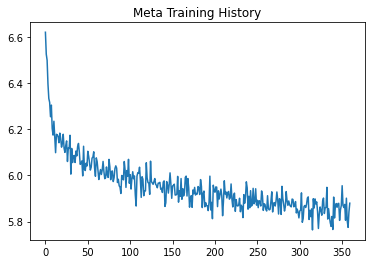

In [15]:
# meta train
meta_history = meta_learner.meta_fit(20, batch_size=10, basic_train=True, bootstrap_train=True, use_test_for_meta=True, randomize=True)
plt.plot(meta_history)
plt.title('Meta Training History')
plt.show()

In [ ]:
meta_weights = meta_learner.meta_model.get_weights()

In [55]:
meta_learner.meta_model.set_weights(meta_weights)

In [16]:
meta_weights = meta_learner.meta_model.get_weights()
trained_meta_model = meta_learner.meta_model
optimizer = tf.keras.optimizers.Adam(0.000001)
trained_meta_model.compile(optimizer=optimizer, loss=gamma_loss)
meta_history_fine_tune = trained_meta_model.fit(train_x, train_y, epochs=30, validation_data=[test_x, test_y])
meta_learner.meta_model.set_weights(meta_weights)

Epoch 1/30
16/16 [==============================] - 12s 97ms/step - loss: 5.9748 - val_loss: 6.7861
Epoch 2/30
16/16 [==============================] - 1s 31ms/step - loss: 5.9655 - val_loss: 6.4503
Epoch 3/30
16/16 [==============================] - 1s 31ms/step - loss: 6.0707 - val_loss: 6.3228
Epoch 4/30
16/16 [==============================] - 0s 31ms/step - loss: 6.0438 - val_loss: nan
Epoch 5/30
16/16 [==============================] - 0s 31ms/step - loss: 5.9490 - val_loss: nan
Epoch 6/30
16/16 [==============================] - 0s 31ms/step - loss: 5.9490 - val_loss: nan
Epoch 7/30
16/16 [==============================] - 1s 31ms/step - loss: 5.9713 - val_loss: nan
Epoch 8/30
16/16 [==============================] - 0s 31ms/step - loss: 5.9675 - val_loss: nan
Epoch 9/30
16/16 [==============================] - 1s 31ms/step - loss: 5.9840 - val_loss: nan
Epoch 10/30
16/16 [==============================] - 1s 31ms/step - loss: 5.9684 - val_loss: nan
Epoch 11/30
16/16 [==========

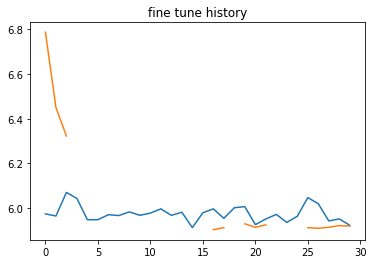

In [17]:
plot_history(meta_history_fine_tune, 'fine tune history')

In [39]:
trained_meta_model = meta_learner.meta_model
untrainded_weights = trained_meta_model.get_weights()

In [53]:
cum = 0
for i in range(len(weights_trained)):
    cum += np.sum(meta_learner.meta_model.get_weights()[i] == meta_weights[i])
cum

60745

In [68]:
def inner_rate_function(inner_rate, batch_size, inner_step):
    return inner_rate/inner_step*math.log(batch_size, 20)

def meta_rate_function(meta_rate, batch_locations, seen_locations, covariance_function, distance_function):
    batch_size = len(batch_location)
    center = np.average(list(seen_locations.keys()), weights=list(seen_locations.values()), axis=0)
    batch_dist = np.mean([distance_function(locat, center) for locat in batch_locations])
    
inner_rate_f(0.01, 100, 5)

NameError: name 'inner_rate_f' is not defined

Text(0.5, 1.0, 'Meta Training History')

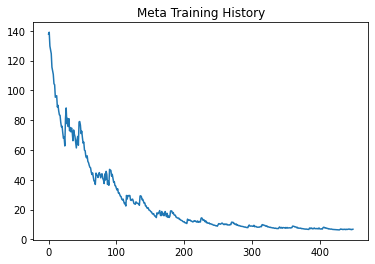

In [66]:
plt.plot(meta_history)
plt.title('Meta Training History')

In [69]:
trained_meta_model = meta_learner.meta_model
optimizer = tf.keras.optimizers.Adam(0.0000001)
trained_meta_model.compile(optimizer=optimizer, loss=gamma_loss)
trained_meta_model.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_148 (InputLayer)         [(None, 10, 1, 3, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_lstm2d_72 (ConvLSTM2D)    (None, 10, 1, 2, 20  3760        ['input_148[0][0]']              
                                )                                                                 
                                                                                                  
 conv_lstm2d_73 (ConvLSTM2D)    (None, 10, 1, 1, 20  6480        ['conv_lstm2d_72[1][0]']         
                                )                                                          

In [31]:
meta_history_fine_tune = trained_meta_model.fit(train_x, train_y, epochs=10)

Epoch 1/10
15/15 [==============================] - 0s 31ms/step - loss: 5.7476
Epoch 2/10
15/15 [==============================] - 0s 31ms/step - loss: 5.7670
Epoch 3/10
15/15 [==============================] - 0s 31ms/step - loss: 5.7426
Epoch 4/10
15/15 [==============================] - 0s 31ms/step - loss: 5.8128
Epoch 5/10
15/15 [==============================] - 0s 29ms/step - loss: 5.7806
Epoch 6/10
15/15 [==============================] - 0s 28ms/step - loss: 5.8076
Epoch 7/10
15/15 [==============================] - 0s 28ms/step - loss: 5.8419
Epoch 8/10
15/15 [==============================] - 0s 28ms/step - loss: 5.8233
Epoch 9/10
15/15 [==============================] - 0s 28ms/step - loss: 5.8088
Epoch 10/10
15/15 [==============================] - 0s 28ms/step - loss: 5.7748


In [34]:
trained_meta_model.predict([])

array([[7.3410058e-07, 7.9987677e-07, 7.5976692e-07, ..., 1.3756335e+00,
        1.0332919e+00, 7.1546888e-01]], dtype=float32)

In [56]:
init_1, init_3 = init
init_2 = np.expand_dims(test_m_data[0, :3, :3], 0)
trained_meta_model.predict([init_1, init_2, init_3])

array([[  0.     ,   0.     ,   0.     , ...,   0.     , 472.80734,
        496.06708]], dtype=float32)

In [57]:
init_1.shape

(1, 10, 1, 3, 3)

In [60]:
np.concatenate([init_1, init_1], 1).shape

(1, 20, 1, 3, 3)

In [102]:
def sequential_predict(model, init_data, predict_steps, l_data):
    init_1, init_3 = init_data
    init_2 = np.expand_dim(l_data[0], 0)
    for i in range(predict_steps):
        y_hat = model.predict([init_1, init_2, init_3])
        alpha_pred, mu_pred= slice_parameter_vectors(y_hat)
        MDN_Yhat = tfd.MixtureSameFamily(
                mixture_distribution=tfd.Categorical(probs=alpha_pred),
                components_distribution=tfd.Exponential(
                    rate=mu_pred))
        init_data.append(np.asarray(MDN_Yhat.sample())[0])
        #print(y_hat[0,0])
        
    return init_data[n_lag:]

In [103]:
sequential_predict(meta_history, init, 3, is_prob=True)

ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 1.

In [105]:
init[0]

array([[[[[225.64253485, 226.47699583, 228.740054  ],
          [226.39021189, 226.69729353, 229.72138011],
          [226.19661694, 225.8895353 , 228.90027051]]],


        [[[251.35415386, 251.11382869, 248.66385126],
          [254.17129411, 253.25004879, 250.52636816],
          [253.89091522, 254.08450976, 253.41694098]]],


        [[[230.24031419, 226.92249735, 226.54865883],
          [230.32709773, 226.90914598, 227.75695833],
          [228.95190645, 226.99592992, 228.60477068]]],


        [[[187.35131558, 188.05893849, 189.74788751],
          [190.86940306, 191.41013377, 193.27265067],
          [193.51297543, 194.54103136, 196.92425191]]],


        [[[203.14151383, 203.20159502, 202.60745881],
          [204.66357065, 206.15892472, 206.85319625],
          [205.52473438, 208.11490125, 210.13095897]]],


        [[[195.85355902, 194.74539444, 194.17128528],
          [203.91778949, 201.80827173, 200.39970201],
          [211.35450571, 208.32374385, 206.20755041]]],


    